In [28]:
import onnx
import torch
import random
import torch.onnx 
import onnxruntime
import torchvision
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from onnxruntime.quantization import quantize_dynamic, QuantType

In [29]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Обучение модели

In [9]:
transform_train = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.RandomHorizontalFlip(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [31]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    # Put model in eval mode
    model.eval()

    # init test_loss and test_acc
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred, dim=1),dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [14]:
train(net, trainloader, testloader, optimizer, criterion, 30, torch.device(device))

  3%|██▊                                                                                | 1/30 [00:28<13:46, 28.48s/it]

Epoch: 1 | train_loss: 1.6831 | train_acc: 0.3800 | test_loss: 1.4511 | test_acc: 0.4837


  7%|█████▌                                                                             | 2/30 [00:57<13:28, 28.87s/it]

Epoch: 2 | train_loss: 1.3178 | train_acc: 0.5278 | test_loss: 1.2512 | test_acc: 0.5585


 10%|████████▎                                                                          | 3/30 [01:26<13:01, 28.96s/it]

Epoch: 3 | train_loss: 1.1910 | train_acc: 0.5771 | test_loss: 1.1344 | test_acc: 0.5964


 13%|███████████                                                                        | 4/30 [01:55<12:34, 29.01s/it]

Epoch: 4 | train_loss: 1.1119 | train_acc: 0.6078 | test_loss: 1.1332 | test_acc: 0.6046


 17%|█████████████▊                                                                     | 5/30 [02:24<12:04, 28.99s/it]

Epoch: 5 | train_loss: 1.0627 | train_acc: 0.6244 | test_loss: 1.1058 | test_acc: 0.6165


 20%|████████████████▌                                                                  | 6/30 [02:54<11:38, 29.11s/it]

Epoch: 6 | train_loss: 1.0191 | train_acc: 0.6427 | test_loss: 1.0935 | test_acc: 0.6223


 23%|███████████████████▎                                                               | 7/30 [03:23<11:09, 29.09s/it]

Epoch: 7 | train_loss: 0.9888 | train_acc: 0.6547 | test_loss: 1.1035 | test_acc: 0.6170


 27%|██████████████████████▏                                                            | 8/30 [03:51<10:34, 28.86s/it]

Epoch: 8 | train_loss: 0.9594 | train_acc: 0.6647 | test_loss: 1.0648 | test_acc: 0.6300


 30%|████████████████████████▉                                                          | 9/30 [04:19<10:00, 28.61s/it]

Epoch: 9 | train_loss: 0.9338 | train_acc: 0.6728 | test_loss: 1.0629 | test_acc: 0.6361


 33%|███████████████████████████▎                                                      | 10/30 [04:48<09:35, 28.77s/it]

Epoch: 10 | train_loss: 0.9143 | train_acc: 0.6797 | test_loss: 1.0462 | test_acc: 0.6428


 37%|██████████████████████████████                                                    | 11/30 [05:17<09:08, 28.84s/it]

Epoch: 11 | train_loss: 0.8945 | train_acc: 0.6839 | test_loss: 1.0872 | test_acc: 0.6294


 40%|████████████████████████████████▊                                                 | 12/30 [05:46<08:40, 28.89s/it]

Epoch: 12 | train_loss: 0.8845 | train_acc: 0.6909 | test_loss: 1.0332 | test_acc: 0.6419


 43%|███████████████████████████████████▌                                              | 13/30 [06:15<08:11, 28.94s/it]

Epoch: 13 | train_loss: 0.8653 | train_acc: 0.6967 | test_loss: 1.0278 | test_acc: 0.6527


 47%|██████████████████████████████████████▎                                           | 14/30 [06:45<07:44, 29.06s/it]

Epoch: 14 | train_loss: 0.8532 | train_acc: 0.6999 | test_loss: 1.1380 | test_acc: 0.6153


 50%|█████████████████████████████████████████                                         | 15/30 [07:14<07:15, 29.06s/it]

Epoch: 15 | train_loss: 0.8441 | train_acc: 0.7044 | test_loss: 1.0696 | test_acc: 0.6516


 53%|███████████████████████████████████████████▋                                      | 16/30 [07:43<06:47, 29.12s/it]

Epoch: 16 | train_loss: 0.8327 | train_acc: 0.7092 | test_loss: 1.0804 | test_acc: 0.6378


 57%|██████████████████████████████████████████████▍                                   | 17/30 [08:11<06:15, 28.86s/it]

Epoch: 17 | train_loss: 0.8173 | train_acc: 0.7134 | test_loss: 1.0810 | test_acc: 0.6393


 60%|█████████████████████████████████████████████████▏                                | 18/30 [08:40<05:46, 28.88s/it]

Epoch: 18 | train_loss: 0.8145 | train_acc: 0.7136 | test_loss: 1.0510 | test_acc: 0.6512


 63%|███████████████████████████████████████████████████▉                              | 19/30 [09:09<05:18, 28.92s/it]

Epoch: 19 | train_loss: 0.8082 | train_acc: 0.7158 | test_loss: 1.0986 | test_acc: 0.6405


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [09:39<04:50, 29.08s/it]

Epoch: 20 | train_loss: 0.8019 | train_acc: 0.7212 | test_loss: 1.0777 | test_acc: 0.6476


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [10:08<04:22, 29.22s/it]

Epoch: 21 | train_loss: 0.7887 | train_acc: 0.7258 | test_loss: 1.0977 | test_acc: 0.6347


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [10:37<03:54, 29.27s/it]

Epoch: 22 | train_loss: 0.7874 | train_acc: 0.7245 | test_loss: 1.0950 | test_acc: 0.6423


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [11:06<03:24, 29.16s/it]

Epoch: 23 | train_loss: 0.7800 | train_acc: 0.7266 | test_loss: 1.1170 | test_acc: 0.6415


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [11:35<02:53, 29.00s/it]

Epoch: 24 | train_loss: 0.7842 | train_acc: 0.7275 | test_loss: 1.1198 | test_acc: 0.6422


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [12:04<02:25, 29.01s/it]

Epoch: 25 | train_loss: 0.7695 | train_acc: 0.7336 | test_loss: 1.1028 | test_acc: 0.6448


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [12:33<01:56, 29.02s/it]

Epoch: 26 | train_loss: 0.7663 | train_acc: 0.7328 | test_loss: 1.1187 | test_acc: 0.6389


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [13:02<01:27, 29.01s/it]

Epoch: 27 | train_loss: 0.7591 | train_acc: 0.7351 | test_loss: 1.1365 | test_acc: 0.6444


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [13:31<00:58, 29.11s/it]

Epoch: 28 | train_loss: 0.7579 | train_acc: 0.7366 | test_loss: 1.1236 | test_acc: 0.6275


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [13:59<00:28, 28.75s/it]

Epoch: 29 | train_loss: 0.7546 | train_acc: 0.7340 | test_loss: 1.1893 | test_acc: 0.6369


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [14:28<00:00, 28.94s/it]

Epoch: 30 | train_loss: 0.7505 | train_acc: 0.7387 | test_loss: 1.1927 | test_acc: 0.6345


{'train_loss': [1.6830985638415814,
  1.3178452489221095,
  1.1910316451999545,
  1.111901204713881,
  1.0626530987127871,
  1.0191311053014547,
  0.988806491099894,
  0.9594126446314156,
  0.9338182252855226,
  0.9142739213924506,
  0.89453597165877,
  0.8845106114817225,
  0.8653357661762834,
  0.8531617735653091,
  0.844137845550552,
  0.8327323908097484,
  0.8173038632992725,
  0.8145381621637195,
  0.8081659499361645,
  0.8018955961615779,
  0.7886662771912338,
  0.7874285683956626,
  0.7800272057725536,
  0.7842108443086501,
  0.7695055709837245,
  0.766297054178872,
  0.7590693292949227,
  0.7579061937979388,
  0.7546242004022142,
  0.7504899050029413],
 'train_acc': [0.38002,
  0.52778,
  0.5771,
  0.60782,
  0.62438,
  0.64268,
  0.6547,
  0.66474,
  0.67284,
  0.67974,
  0.6839,
  0.69088,
  0.6967,
  0.69988,
  0.70444,
  0.70922,
  0.7134,
  0.71358,
  0.7158,
  0.72118,
  0.72582,
  0.7245,
  0.72662,
  0.72748,
  0.73362,
  0.7328,
  0.73512,
  0.73662,
  0.73404,
  0.738

In [16]:
torch.save(net, 'F:/model_usage_2/models/cifar10.pt')

## Инференс PyTorch модели

In [8]:
model = Net() 
model = torch.load('F:/model_usage_2/models/cifar10.pt', weights_only=False)
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
def prepare_pic(pic_path, image_size =(32, 32)):
    img = Image.open(pic_path)

    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    transformed_image = image_transform(img).unsqueeze(dim=0)
    return transformed_image

In [6]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (32, 32),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);
    return class_names[target_image_pred_label], target_image_pred_probs.max(), target_image_pred


In [7]:
import requests

# Setup custom image path
def predict_enet_pic(pic_url, pic_name, cur_data_path, model, class_names):
    custom_image_path = cur_data_path / pic_name
    url_link = pic_url
    # Download the image if it doesn't already exist
    if not custom_image_path.is_file():
        with open(custom_image_path, "wb") as f:
            # When downloading from GitHub, need to use the "raw" file link
            request = requests.get(url_link)
            print(f"Downloading {custom_image_path}...")
            f.write(request.content)
    else:
        print(f"{custom_image_path} already exists, skipping download.")

    # Predict on custom image
    return pred_and_plot_image(model=model,
                               image_path=custom_image_path,
                               class_names=class_names)

In [40]:
samples_dir = Path('F:/model_usage_2/samples')

F:\model_usage_2\samples\frog_0.jpg already exists, skipping download.


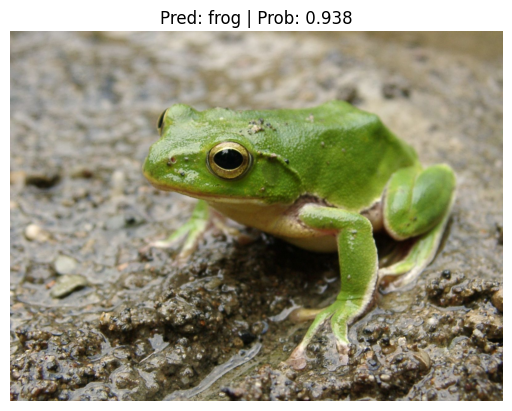

In [14]:
class_name, prob_class, raw_output = predict_enet_pic('https://i.pinimg.com/originals/18/a0/25/18a0250c2e6d09c6c8723b73f337f478.jpg','frog_0.jpg',samples_dir, model, classes)

F:\model_usage_2\samples\lorry_0.jpg already exists, skipping download.


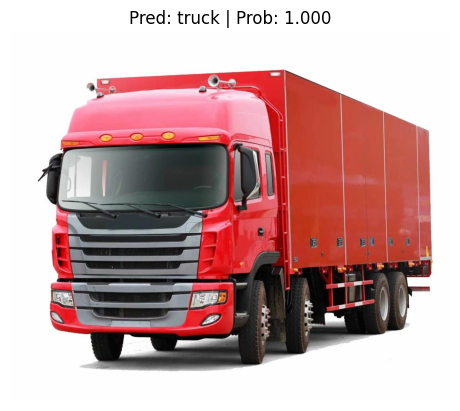

In [15]:
class_name, prob_class, raw_output = predict_enet_pic('https://avatars.mds.yandex.net/i?id=5831b76224b32a1e5d5a278b95f61021_l-5694293-images-thumbs&n=13','lorry_0.jpg',samples_dir, model, classes)

F:\model_usage_2\samples\lorry_1.jpg already exists, skipping download.


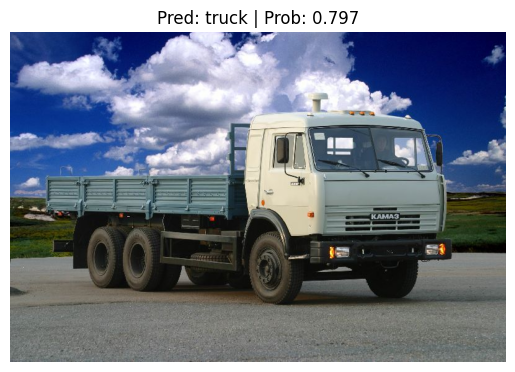

In [16]:
class_name, prob_class, raw_output = predict_enet_pic('https://i.pinimg.com/originals/2e/bf/33/2ebf333a2ece9395ba205f0abdf9f766.jpg','lorry_1.jpg',samples_dir, model, classes)

## Переведем в ONNX

In [32]:
model = Net().to(device)
model = torch.load('F:/model_usage_2/models/cifar10.pt', weights_only=False)
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
onnx_model_path = "F:/model_usage_2/models/cifar10.onnx"

In [50]:
batch_size = 1 
x = torch.randn(batch_size, 3, 32, 32, requires_grad=True).to(device)
torch_out = model(x)

In [51]:
# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  onnx_model_path,            # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [52]:
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

In [53]:
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CUDAExecutionProvider"]) # CPUExecutionProvider

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-02, atol=1e-04)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [39]:
import time

x = prepare_pic('F:/model_usage_2/samples/frog_0.jpg')

start = time.time()
torch_out = model(x.to(device))
end = time.time()
print(f"Inference of Pytorch model used {end - start} seconds")

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
start = time.time()
ort_outs = ort_session.run(None, ort_inputs)
end = time.time()
print(f"Inference of ONNX model used {end - start} seconds")

Inference of Pytorch model used 0.0010001659393310547 seconds
Inference of ONNX model used 0.0009999275207519531 seconds


In [64]:
def predict_onnx_pic(pic_url, pic_name, cur_data_path, onnx_model_path, class_names):
    ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CUDAExecutionProvider"])
    custom_image_path = cur_data_path / pic_name
    url_link = pic_url
    # Download the image if it doesn't already exist
    if not custom_image_path.is_file():
        with open(custom_image_path, "wb") as f:
            # When downloading from GitHub, need to use the "raw" file link
            request = requests.get(url_link)
            print(f"Downloading {custom_image_path}...")
            f.write(request.content)
    else:
        print(f"{custom_image_path} already exists, skipping download.")
    image = prepare_pic(custom_image_path)
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}
    target_image_pred = torch.from_numpy(ort_session.run(None, ort_inputs)[0])

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(Image.open(custom_image_path))
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);
    return class_names[target_image_pred_label], target_image_pred_probs.max(), target_image_pred

F:\model_usage_2\samples\lorry_1.jpg already exists, skipping download.


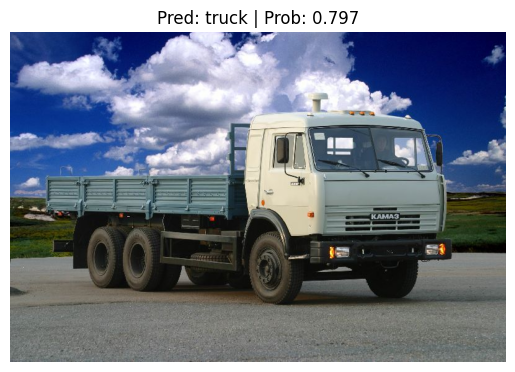

In [55]:
class_food, prob, raw_output = predict_onnx_pic('https://i.pinimg.com/originals/2e/bf/33/2ebf333a2ece9395ba205f0abdf9f766.jpg','lorry_1.jpg',samples_dir, "F:/model_usage_2/models/cifar10.onnx", classes)

F:\model_usage_2\samples\plane_0.jpg already exists, skipping download.


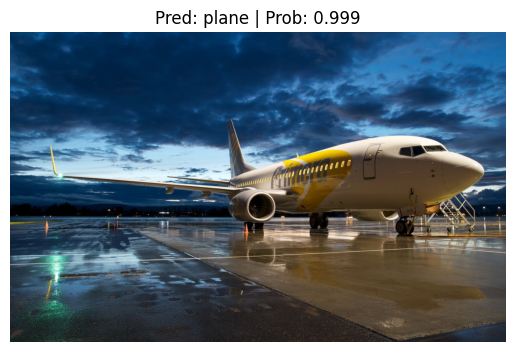

In [56]:
class_food, prob, raw_output = predict_onnx_pic('https://i.pinimg.com/originals/1f/56/4a/1f564afe164967e0ea1c9959c019b08a.jpg','plane_0.jpg',samples_dir, "F:/model_usage_2/models/cifar10.onnx", classes)

## Оптимизация PyTorch

In [40]:
class QuantizedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model_fp32 = model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x

In [41]:
model = Net().to('cpu')
model = torch.load('F:/model_usage_2/models/cifar10.pt', weights_only=False)
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [46]:
q_model = QuantizedModel(model).to('cpu')
q_model.eval()

QuantizedModel(
  (model_fp32): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [47]:
backend = "x86"
q_model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

In [48]:
model_static_quantized = torch.quantization.prepare(q_model, inplace=False)
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)

C:\Users\dan\anaconda3\envs\model_usage\lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
C:\Users\dan\anaconda3\envs\model_usage\lib\site-packages\torch\ao\quantization\observer.py:1318: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [49]:
model_static_quantized(torch.rand((1, 3, 32, 32), dtype=torch.float32, device="cpu"))

tensor([[0., 0., 3., 1., 4., 0., 5., 0., 0., 0.]])

In [80]:
#torch.save(model_static_quantized, 'F:/model_usage_2/models/cifar10_int8.pt')

In [81]:
#torch.save(model_static_quantized.state_dict(), 'F:/model_usage_2/models/cifar10_int8_params.pt')

In [63]:
print(model_static_quantized)

QuantizedModel(
  (model_fp32): Net(
    (conv1): QuantizedConv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), scale=1.0, zero_point=0)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): QuantizedConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=1.0, zero_point=0)
    (fc1): QuantizedLinear(in_features=400, out_features=120, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
    (fc2): QuantizedLinear(in_features=120, out_features=84, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
    (fc3): QuantizedLinear(in_features=84, out_features=10, scale=1.0, zero_point=0, qscheme=torch.per_channel_affine)
  )
  (quant): Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)


In [69]:
torch.jit.save(torch.jit.script(model_static_quantized), 'F:/model_usage_2/models/jit_int8_cifar10.pt')

## Инференс квантованной модели

In [28]:
def predict_jit_quant(model, image_path, classes):
    transformed_image = prepare_pic(image_path)
    target_image_pred = model(transformed_image)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    plt.figure()
    plt.imshow(Image.open(image_path))
    plt.title(f"Pred: {classes[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


In [29]:
m = torch.jit.load('F:/model_usage_2/models/jit_int8_cifar10.pt')

In [30]:
m(torch.rand((1, 3, 32, 32), dtype=torch.float32, device="cpu"))

tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [31]:
x = prepare_pic('F:/model_usage_2/samples/frog_0.jpg')

In [32]:
m(x)

tensor([[0., 0., 3., 2., 3., 1., 2., 0., 0., 0.]])

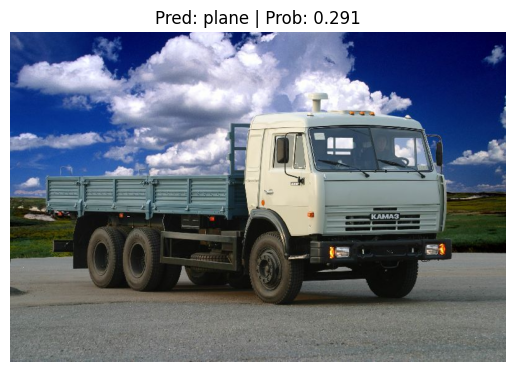

In [36]:
predict_jit_quant(m, 'F:/model_usage_2/samples/lorry_1.jpg', classes)

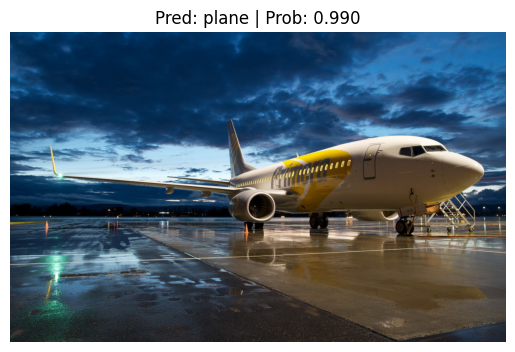

In [57]:
predict_jit_quant(m, 'F:/model_usage_2/samples/plane_0.jpg', classes)

## ONNX оптимизация

In [74]:
model_fp32 = 'F:/model_usage_2/models/cifar10.onnx'
model_quant = 'F:/model_usage_2/models/cifar10_quant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QInt8, nodes_to_exclude=['/conv1/Conv', '/conv2/Conv'])

In [75]:
q_onnx_model = onnx.load(model_quant)
onnx.checker.check_model(q_onnx_model)

In [76]:
x = torch.randn(batch_size, 3, 32, 32, requires_grad=True)

In [79]:
ort_session = onnxruntime.InferenceSession(model_quant, providers=["CUDAExecutionProvider"]) # CPUExecutionProvider

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

In [80]:
ort_outs

[array([[-3.4255805,  3.9228332,  1.8550817,  3.174032 , -2.1587493,
         -1.5604832, 14.074986 , -4.4414563, -0.5232393,  4.810784 ]],
       dtype=float32)]

F:\model_usage_2\samples\plane_0.jpg already exists, skipping download.


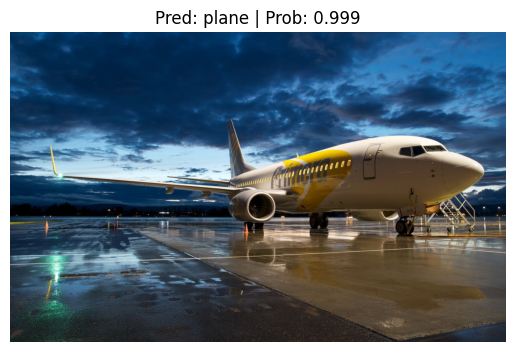

In [81]:
class_food, prob, raw_output = predict_onnx_pic('https://i.pinimg.com/originals/1f/56/4a/1f564afe164967e0ea1c9959c019b08a.jpg','plane_0.jpg',samples_dir, "F:/model_usage_2/models/cifar10_quant.onnx", classes)

F:\model_usage_2\samples\lorry_1.jpg already exists, skipping download.


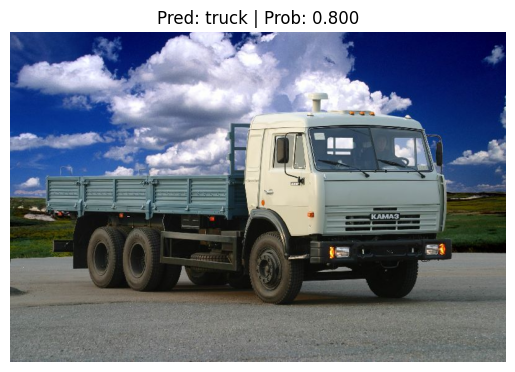

In [82]:
class_food, prob, raw_output = predict_onnx_pic('https://i.pinimg.com/originals/2e/bf/33/2ebf333a2ece9395ba205f0abdf9f766.jpg','lorry_1.jpg',samples_dir, "F:/model_usage_2/models/cifar10_quant.onnx", classes)

## Предобработка текста для Docker

### Создадим модели

In [5]:
model = Net() # PyTorch
model = torch.load('F:/model_usage_2/models/cifar10.pt', weights_only=False)
model.to('cpu')
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
torch.jit.save(torch.jit.script(model), "F:/model_usage_2/models/jit_cifar10.pt")

In [6]:
onnx_model_path = "F:/model_usage_2/models/cifar10.onnx" # ONNX
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

In [7]:
ort_session_q = onnxruntime.InferenceSession('F:/model_usage_2/models/cifar10_quant.onnx', providers=["CPUExecutionProvider"]) # ONNX quantized 

In [8]:
m = torch.jit.load('F:/model_usage_2/models/jit_int8_cifar10.pt') # Pytorch quantized

In [9]:
import io
import base64
import torchvision
from PIL import Image
import torchvision.transforms as transforms

In [15]:
def to_numpy(tensor): #V1
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def prepare_pic(pic_str, image_size =(32, 32)):
    f = io.BytesIO(base64.b64decode(pic_str))
    img = Image.open(f)

    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    transformed_image = image_transform(img).unsqueeze(dim=0)
    return transformed_image, to_numpy(transformed_image)

In [23]:
def preprocess_image(pic_str): # V2
    image_size =(32, 32)
    f = io.BytesIO(base64.b64decode(pic_str))
    img = Image.open(f)
    print(type(img))
    transformed_image = transform_image(img)
    return transformed_image.tolist()

def transform_image(image):
    image = image.resize((32, 32))
    image_array = np.array(image)
    image_array = image_array / 255.0  # Масштабирование в диапазон [0, 1]
    image_array = (image_array - 0.5) / 0.5  # Нормализация до [-1, 1]
    return image_array

In [24]:
def pic_to_str(pic_path):
    with open(pic_path, "rb") as image:
        b64string = base64.b64encode(image.read()).decode('ASCII')
    return b64string

In [25]:
type(pic_to_str('F:/model_usage_2/samples/frog_0.jpg'))

str

In [26]:
json_pic = preprocess_image(pic_to_str('F:/model_usage_2/samples/frog_0.jpg'))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [27]:
json_pic

[[[0.19999999999999996, 0.1607843137254903, 0.08235294117647052],
  [0.3254901960784313, 0.2941176470588236, 0.24705882352941178],
  [0.3647058823529412, 0.33333333333333326, 0.2784313725490195],
  [0.43529411764705883, 0.39607843137254894, 0.3411764705882352],
  [0.30980392156862746, 0.2549019607843137, 0.15294117647058814],
  [0.0117647058823529, -0.04313725490196074, -0.23921568627450984],
  [0.23921568627450984, 0.1607843137254903, -0.06666666666666665],
  [0.39607843137254894, 0.3254901960784313, 0.17647058823529416],
  [0.4274509803921569, 0.39607843137254894, 0.33333333333333326],
  [0.5215686274509803, 0.4901960784313726, 0.4274509803921569],
  [0.5529411764705883, 0.4980392156862745, 0.37254901960784315],
  [0.607843137254902, 0.5529411764705883, 0.41960784313725497],
  [0.607843137254902, 0.5529411764705883, 0.4274509803921569],
  [0.34901960784313735, 0.3019607843137255, 0.19215686274509802],
  [0.23921568627450984, 0.19215686274509802, 0.0980392156862746],
  [0.505882352941

In [13]:
x0, x1 = prepare_pic(pic_to_str('F:/model_usage_2/samples/frog_0.jpg'))

In [7]:
x1

array([[[[ 0.20784318,  0.3176471 ,  0.35686278, ...,  0.13725495,
           0.082353  ,  0.06666672],
         [ 0.2313726 ,  0.2313726 ,  0.2941177 , ...,  0.14509809,
           0.10588241,  0.07450986],
         [ 0.17647064,  0.2941177 ,  0.32549024, ...,  0.24705887,
           0.1686275 ,  0.09803927],
         ...,
         [ 0.02745104,  0.00392163, -0.12156862, ..., -0.0745098 ,
          -0.14509803, -0.44313723],
         [ 0.12156868,  0.10588241, -0.05098039, ..., -0.26274508,
          -0.23137254, -0.3960784 ],
         [ 0.0196079 , -0.15294117, -0.46666664, ..., -0.18431371,
          -0.32549018, -0.34117645]],

        [[ 0.1686275 ,  0.28627455,  0.32549024, ...,  0.0196079 ,
          -0.02745098, -0.03529412],
         [ 0.18431377,  0.19215691,  0.254902  , ...,  0.02745104,
          -0.01176471, -0.03529412],
         [ 0.13725495,  0.24705887,  0.27843142, ...,  0.13725495,
           0.06666672,  0.00392163],
         ...,
         [-0.05882353, -0.05098039

In [14]:
x0

tensor([[[[ 0.2078,  0.3176,  0.3569,  ...,  0.1373,  0.0824,  0.0667],
          [ 0.2314,  0.2314,  0.2941,  ...,  0.1451,  0.1059,  0.0745],
          [ 0.1765,  0.2941,  0.3255,  ...,  0.2471,  0.1686,  0.0980],
          ...,
          [ 0.0275,  0.0039, -0.1216,  ..., -0.0745, -0.1451, -0.4431],
          [ 0.1216,  0.1059, -0.0510,  ..., -0.2627, -0.2314, -0.3961],
          [ 0.0196, -0.1529, -0.4667,  ..., -0.1843, -0.3255, -0.3412]],

         [[ 0.1686,  0.2863,  0.3255,  ...,  0.0196, -0.0275, -0.0353],
          [ 0.1843,  0.1922,  0.2549,  ...,  0.0275, -0.0118, -0.0353],
          [ 0.1373,  0.2471,  0.2784,  ...,  0.1373,  0.0667,  0.0039],
          ...,
          [-0.0588, -0.0510, -0.1529,  ..., -0.1529, -0.2235, -0.5216],
          [ 0.0588,  0.0431, -0.1373,  ..., -0.3490, -0.3098, -0.4667],
          [-0.0667, -0.2549, -0.5451,  ..., -0.2627, -0.4275, -0.4275]],

         [[ 0.0902,  0.2314,  0.2706,  ..., -0.2627, -0.3176, -0.3255],
          [ 0.0980,  0.1137,  

In [80]:
model(x0) # Для обычной модели подходит

tensor([[-2.0246, -3.3331,  4.2820,  1.1256,  5.0604,  0.6631,  8.1768, -1.8992,
         -2.3993, -3.7763]], grad_fn=<AddmmBackward0>)

In [81]:
ort_inputs = {ort_session.get_inputs()[0].name: x1} # ONNX
target_image_pred = torch.from_numpy(ort_session.run(None, ort_inputs)[0])
target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

In [82]:
target_image_pred_probs

tensor([[3.4812e-05, 9.4075e-06, 1.9084e-02, 8.1258e-04, 4.1562e-02, 5.1169e-04,
         9.3792e-01, 3.9465e-05, 2.3934e-05, 6.0390e-06]])

In [83]:
m(x0) # Pytorch quantized

tensor([[0., 0., 3., 2., 3., 1., 2., 0., 0., 0.]])

In [84]:
ort_inputs = {ort_session_q.get_inputs()[0].name: x1} # ONNX quantized
target_image_pred = torch.from_numpy(ort_session.run(None, ort_inputs)[0])
target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

In [85]:
target_image_pred_probs

tensor([[3.4812e-05, 9.4075e-06, 1.9084e-02, 8.1258e-04, 4.1562e-02, 5.1169e-04,
         9.3792e-01, 3.9465e-05, 2.3934e-05, 6.0390e-06]])